# Módulo 8 - Regressão Linear Múltipla



In [53]:
# pipenv install scikit-learn scipy pandas matplotlib seaborn ipykernel gradio

"""Lista de Importação de todos os módulos que serão utilizado no notebook"""

# AED
import pandas as pd


import seaborn as sns


import matplotlib.pyplot as plt



# Model Trainning

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


from sklearn.compose import ColumnTransformer


from sklearn.pipeline import Pipeline


from sklearn.impute import SimpleImputer


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import numpy as np



# Model Validation


from scipy.stats import zscore, shapiro, kstest, anderson


from statsmodels.stats.diagnostic import lilliefors, het_goldfeldquandt


import pingouin as pg



# Model Prediction


import joblib

### AED



#### Carga do Dados



Nesta etapa, foi destacada a importância de utilizar nomes de colunas técnicos em um DataFrame, facilitando a referência e evitando problemas com acentuação, maiúsculas e minúsculas. As colunas foram renomeadas utilizando o atributo "columns" do DataFrame, atribuindo uma lista com os novos nomes. Também foi aplicado o conceito de Bucketing, transformando variáveis numéricas em categóricas para análises específicas. Para isso, cópias do DataFrame original foram criadas para realizar a análise exploratória e o Bucketing, mantendo o DataFrame original intacto para o treinamento do modelo.


In [2]:
# carregar o dataset
df_colesterol = pd.read_csv("./datasets/dataset_colesterol.csv")
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Grupo Sanguíneo     996 non-null    object 
 2   Fumante             997 non-null    object 
 3   Nível de Atividade  996 non-null    object 
 4   Idade               997 non-null    float64
 5   Peso                997 non-null    float64
 6   Altura              997 non-null    float64
 7   Colesterol          1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


In [3]:
# remover coluna "Id"
df_colesterol.drop(columns=["Id"], axis=1, inplace=True)
df_colesterol.head(3)

,Grupo Sanguíneo,Fumante,Nível de Atividade,Idade,Peso,Altura,Colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79


In [4]:
# renomear colunas
df_colesterol.columns = [
    "grupo_sanguineo",
    "fumante",
    "nivel_atividade_fisica",
    "idade",
    "peso",
    "altura",
    "nivel_colesterol",
]

In [5]:
# copiar DF para DF AED
df_colesterol_eda = df_colesterol.copy()
df_colesterol_eda.head(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98


In [6]:
# copiar DF para DF Bucketing
df_colesterol_bucketing = df_colesterol.copy()
df_colesterol_bucketing.tail(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
998,AB,Sim,Baixo,61.0,91.2,161.0,284.53
999,A,Não,Baixo,45.0,82.4,163.0,237.45


#### Lidando com Valores Ausentes



Foi realizada a análise das medidas estatísticas das variáveis numéricas, como idade, peso e altura, para identificar outliers e determinar a melhor abordagem para tratar valores ausentes. A mediana foi escolhida por ser menos sensível a outliers, enquanto para variáveis categóricas utilizou-se a moda, ou seja, o valor mais frequente. Também foi demonstrado como coletar essas medidas estatísticas e realizar a imputação dos valores ausentes de forma eficiente. Além disso, foi reforçada a importância de verificar o domínio das variáveis categóricas e converter variáveis numéricas para os tipos adequados.



In [7]:
# visualizar dados
df_colesterol_eda.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79
3,A,Não,Alto,43.0,120.2,167.0,336.24
4,AB,Não,Baixo,79.0,88.5,175.0,226.23
5,B,Não,Baixo,68.0,66.8,170.0,185.31
6,A,Sim,Baixo,60.0,117.3,181.0,289.33


In [8]:
# visualizar valores únicos das colunas
print(
    f"Grupos Sanguíneos do paciente: {df_colesterol_eda['grupo_sanguineo'].unique()}")
print(f"Paciente é Fumante?: {df_colesterol_eda['fumante'].unique()}")
print(
    f"Nivel de atividade física do paciente: {df_colesterol_eda['nivel_atividade_fisica'].unique()}"
)

Grupos Sanguíneos do paciente: ['B' 'A' 'O' 'AB' nan]
Paciente é Fumante?: ['Sim' 'Não' nan]
Nivel de atividade física do paciente: ['Baixo' 'Moderado' 'Alto' nan]


In [9]:
# detectar quantidade valores ausentes (nulos) por coluna
df_colesterol_eda.isna().sum()

grupo_sanguineo           4
fumante                   3
nivel_atividade_fisica    4
idade                     3
peso                      3
altura                    3
nivel_colesterol          0
dtype: int64

In [10]:
# medidas estatísticas do DataFrame
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,997.000000,997.000000,997.000000,1000.000000
mean,49.206620,76.496690,174.889669,199.453260
std,17.476704,21.439132,8.844703,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.700000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,65.000000,90.200000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


In [11]:
# coletar medidas de variáveis categóricas
moda_grupo_sanguineo = df_colesterol_eda["grupo_sanguineo"].mode()
moda_fumante = df_colesterol_eda["fumante"].mode()
moda_nivel_atividade_fisica = df_colesterol_eda["nivel_atividade_fisica"].mode(
)

In [12]:
# coletar medidade de variáveis numéricas
mediana_idade = df_colesterol_eda["idade"].median()
mediana_peso = df_colesterol_eda["peso"].median()
mediana_altura = df_colesterol_eda["altura"].median()

In [13]:
# imputar valores ausentes
df_colesterol_eda.fillna(
    value={
        "grupo_saguineo": moda_grupo_sanguineo[0],
        "fumante": moda_fumante[0],
        "nivel_atividade_fisica": moda_nivel_atividade_fisica[0],
        "idade": mediana_idade,
        "peso": mediana_peso,
        "altura": mediana_altura,
    },
    inplace=True,
)

#### Convertendo Variáveis Numéricas



Foi realizada a conversão dos tipos de dados em um DataFrame, começando pelo tratamento de valores ausentes para evitar erros durante o processo. Em seguida, utilizou-se o método type para alterar o tipo das variáveis, convertendo, por exemplo, idade e altura para inteiros. Após a conversão, verificou-se que o DataFrame apresentava as colunas ajustadas como inteiros e os valores ausentes devidamente tratados.



In [14]:
# converter idade e altura para números inteiros
df_colesterol_eda["idade"] = df_colesterol_eda["idade"].astype(int)
df_colesterol_eda["altura"] = df_colesterol_eda["altura"].astype(int)
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         996 non-null    object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   int64  
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   int64  
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [15]:
df_colesterol_eda.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98
2,O,Não,Alto,25,64.8,180,161.79
3,A,Não,Alto,43,120.2,167,336.24
4,AB,Não,Baixo,79,88.5,175,226.23
5,B,Não,Baixo,68,66.8,170,185.31
6,A,Sim,Baixo,60,117.3,181,289.33


#### Tratamento de Outliers



Foi iniciada a análise dos dados preparados, com foco na identificação de outliers. A variável peso foi analisada com um boxplot, resultando na exclusão de registros com peso abaixo de 40 quilos devido à possível inconsistência dos dados. A variável altura não apresentou outliers, enquanto o nível de colesterol apresentou valores extremos que foram mantidos no estudo. Após as remoções, os boxplots foram revisados, confirmando a ausência de outliers na idade e a necessidade de excluir valores muito baixos de peso para alinhar ao contexto do estudo, reduzindo o público analisado.



<Axes: xlabel='idade'>

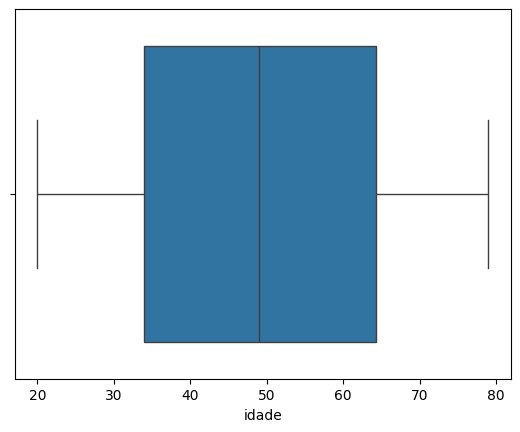

In [16]:
# verificar / detectar outliers - sem outliers no campo "idade"
sns.boxplot(data=df_colesterol_eda, x="idade")

<Axes: xlabel='peso'>

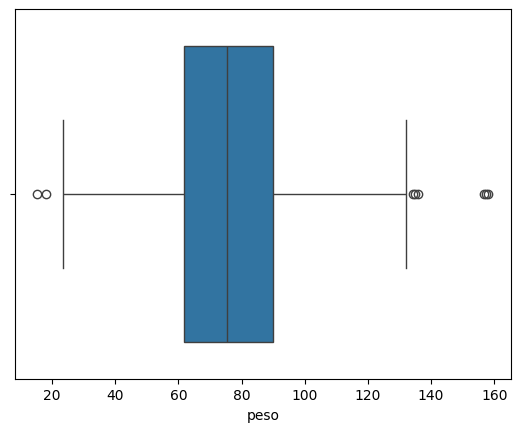

In [17]:
# verificar / detectar outliers - presença de outliers no campo "peso"
sns.boxplot(data=df_colesterol_eda, x="peso")

In [18]:
# Filtrar o público a ser removido
df_colesterol_eda[df_colesterol_eda["peso"] < 40]["peso"].count()

np.int64(37)

In [19]:
df_colesterol_eda.drop(
    df_colesterol_eda[df_colesterol_eda["peso"] < 40].index, axis=0, inplace=True
)
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 963 non-null    object 
 2   nivel_atividade_fisica  963 non-null    object 
 3   idade                   963 non-null    int64  
 4   peso                    963 non-null    float64
 5   altura                  963 non-null    int64  
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 60.2+ KB


<Axes: xlabel='altura'>

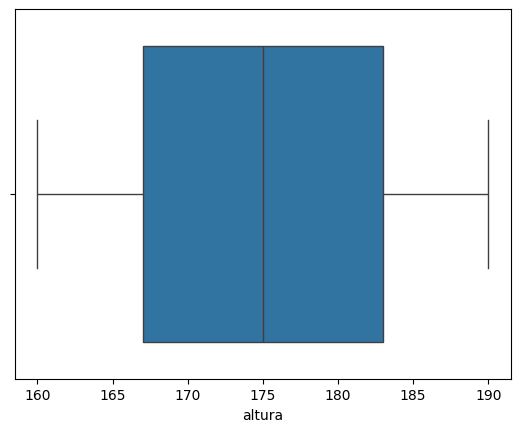

In [20]:
# verificar / detectar outliers - sem presença de outliers no campo "altura"
sns.boxplot(data=df_colesterol_eda, x="altura")

<Axes: xlabel='nivel_colesterol'>

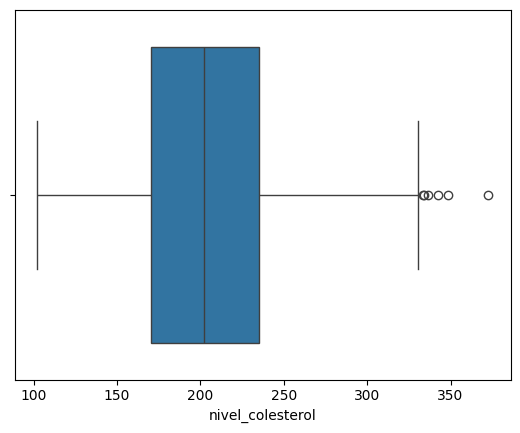

In [21]:
# verificar / detectar outliers - sem outliers no campo "colesterol"
sns.boxplot(data=df_colesterol_eda, x="nivel_colesterol")

#### Análise Grafica



A análise exploratória foi aprofundada com cruzamentos entre variáveis categóricas e o nível de colesterol, utilizando boxplots para identificar padrões. Foi observado que os grupos sanguíneos O e B tendem a ter níveis de colesterol menores em comparação aos tipos A e AB. Fumantes apresentaram níveis mais altos de colesterol, enquanto pessoas com alto nível de atividade física demonstraram níveis mais baixos. Identificou-se uma correlação positiva entre peso e nível de colesterol, embora valores extremos de colesterol para pesos altos tenham sido detectados. Já a análise entre altura e nível de colesterol não revelou padrões claros.

Para avaliar correlações visuais, foi criado um pairplot com o Seaborn, evidenciando que o peso está positivamente correlacionado com o nível de colesterol, enquanto altura e idade se mostraram bem distribuídas. Nenhuma outra correlação significativa foi encontrada entre as variáveis independentes, o que é benéfico para evitar multicolinearidade no modelo. Com isso, a análise prossegue para cruzamentos entre variáveis numéricas e o nível de colesterol.


<Axes: xlabel='grupo_sanguineo', ylabel='nivel_colesterol'>

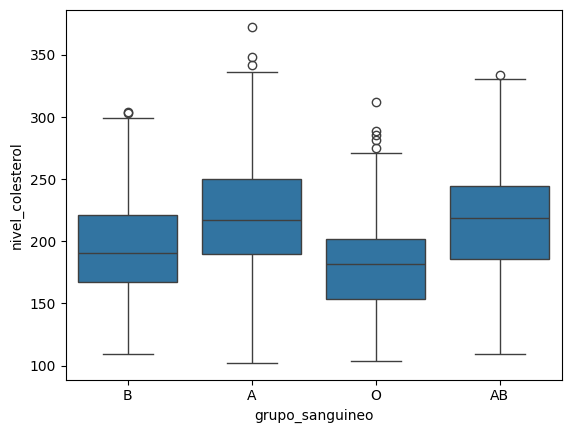

In [22]:
# cruzamento de variáveis categoricas - nível de colesterol
sns.boxplot(data=df_colesterol_eda, x="grupo_sanguineo", y="nivel_colesterol")

<Axes: xlabel='fumante', ylabel='nivel_colesterol'>

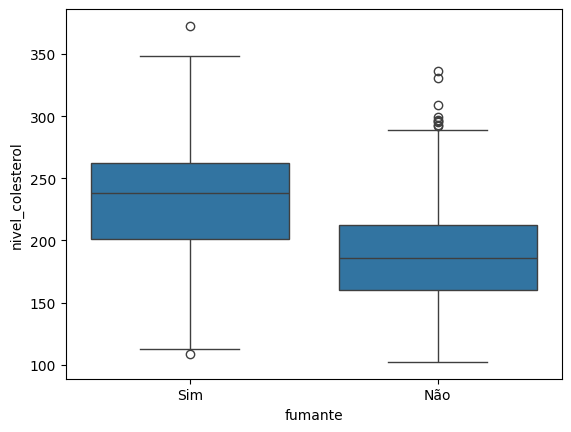

In [23]:
# cruzamento de variáveis categoricas - fumantes
sns.boxplot(data=df_colesterol_eda, x="fumante", y="nivel_colesterol")

<Axes: xlabel='nivel_atividade_fisica', ylabel='nivel_colesterol'>

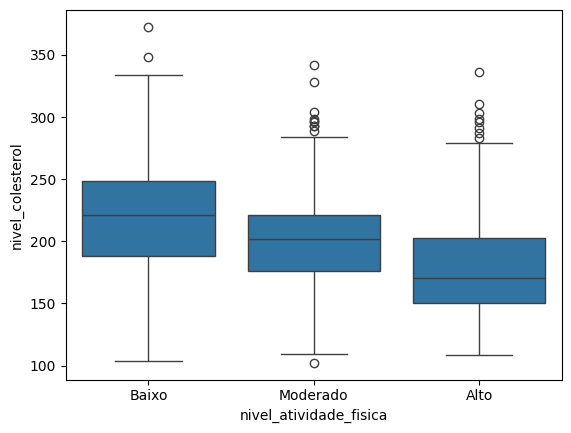

In [24]:
# cruzamento de variáveis categoricas - atividade física
sns.boxplot(data=df_colesterol_eda,
            x="nivel_atividade_fisica", y="nivel_colesterol")

<Axes: xlabel='idade', ylabel='nivel_colesterol'>

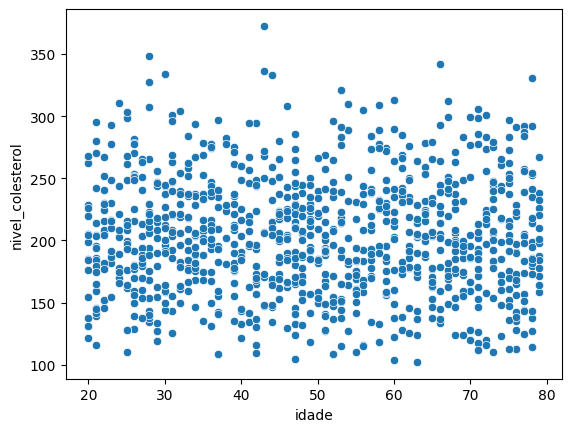

In [25]:
# cruzamento variáveis numéricas com nível de colesterol - idade
sns.scatterplot(data=df_colesterol_eda, x="idade", y="nivel_colesterol")

<Axes: xlabel='peso', ylabel='nivel_colesterol'>

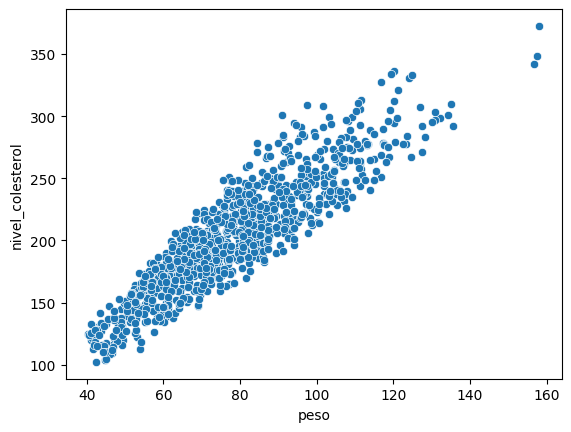

In [26]:
# cruzamento variáveis numéricas com nível de colesterol - peso
sns.scatterplot(data=df_colesterol_eda, x="peso", y="nivel_colesterol")

<Axes: xlabel='altura', ylabel='nivel_colesterol'>

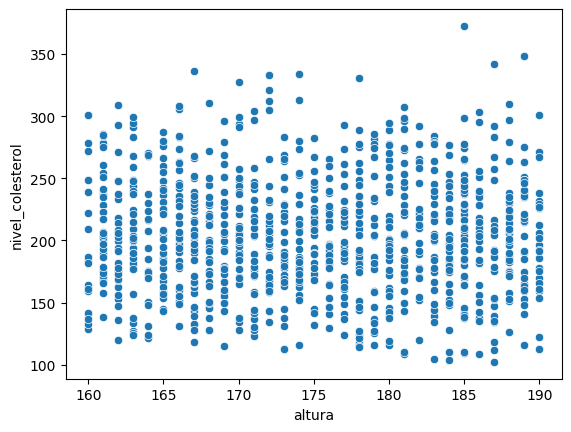

In [27]:
# cruzamento variáveis numéricas com nível de colesterol - altura
sns.scatterplot(data=df_colesterol_eda, x="altura", y="nivel_colesterol")

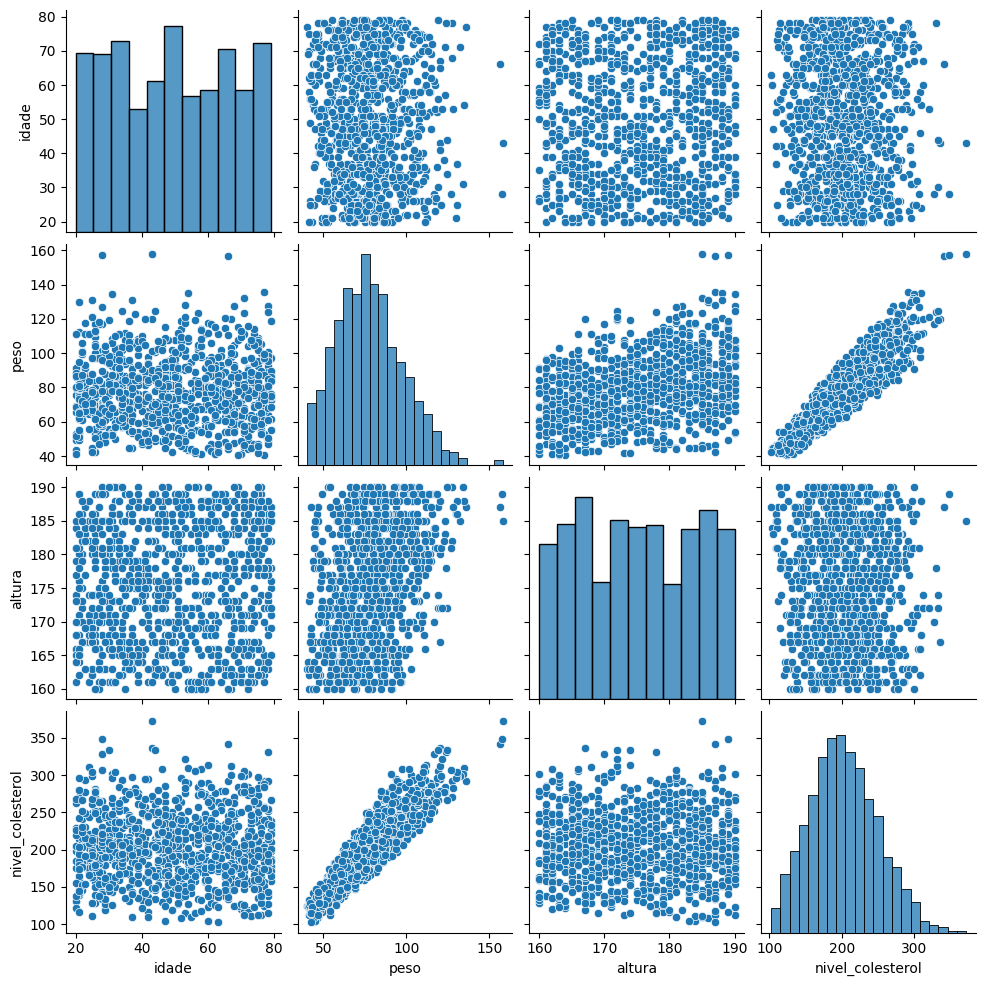

In [28]:
# cruzamento de todas as variáveis numéricas - modo rápido
sns.pairplot(df_colesterol_eda)

#### Análise de Correlação



Foi realizada a conversão de variáveis categóricas em numéricas para análise de correlação. O método get_dummies do Pandas foi utilizado para transformar variáveis nominais, como fumante e grupo sanguíneo, em variáveis binárias, enquanto o método factorize foi aplicado para converter a variável ordinal de nível de atividade física em valores numéricos. Com o DataFrame ajustado, um heatmap de correlação foi plotado usando o Seaborn, destacando correlações importantes: peso, tabagismo e tipo sanguíneo apresentaram correlação positiva com o nível de colesterol, enquanto o nível de atividade física mostrou correlação negativa.



In [29]:
# converter variáveis categóricas nominais em numéricas usando One-Hot Enconder do Pandas
df_colesterol_eda = pd.get_dummies(
    df_colesterol_eda, columns=["grupo_sanguineo", "fumante"], dtype="int64"
)

In [30]:
df_colesterol_eda.head(5)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,Baixo,33,85.1,186,199.63,0,0,1,0,0,1
1,Moderado,68,105.0,184,236.98,1,0,0,0,1,0
2,Alto,25,64.8,180,161.79,0,0,0,1,1,0
3,Alto,43,120.2,167,336.24,1,0,0,0,1,0
4,Baixo,79,88.5,175,226.23,0,1,0,0,1,0


In [31]:
# converter variável categórica em numérica ordinal em numérica usando factorize
df_colesterol_eda["nivel_atividade_fisica"] = (
    pd.factorize(df_colesterol_eda["nivel_atividade_fisica"])[0] + 1
)
df_colesterol_eda.head(3)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,1,33,85.1,186,199.63,0,0,1,0,0,1
1,2,68,105.0,184,236.98,1,0,0,0,1,0
2,3,25,64.8,180,161.79,0,0,0,1,1,0


<Axes: >

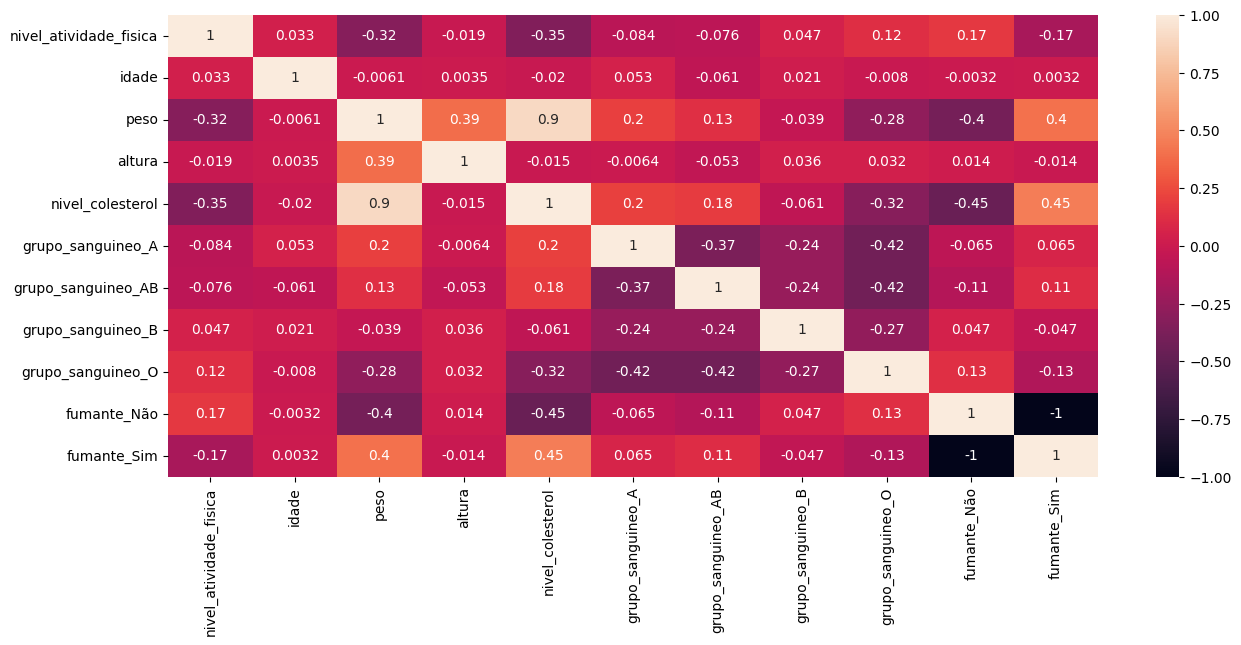

In [32]:
# mapa de calor com correlação entre variáveis
# peso tem uma correlação muito alta
plt.figure(figsize=(15, 6))
sns.heatmap(df_colesterol_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

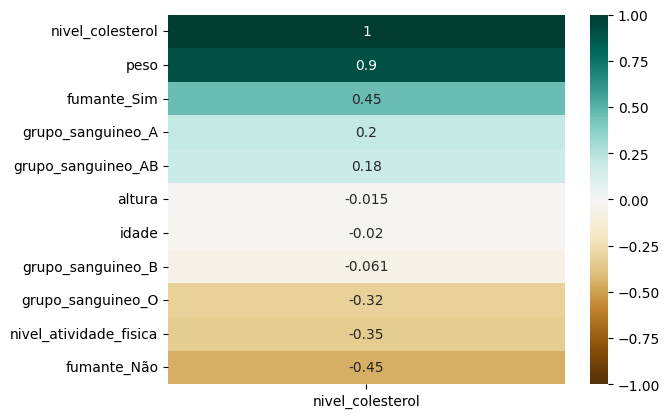

In [33]:
# formato de ranking, somente correlação com a variável target (nível correlação)
sns.heatmap(
    df_colesterol_eda.corr()[["nivel_colesterol"]].sort_values(
        by="nivel_colesterol", ascending=False
    ),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="BrBG",
)

#### Análise Gráfica com Bucketing



Foi aplicado o conceito de bucketing com a biblioteca Pandas, permitindo a análise de ranges de valores em vez de valores individuais. A variável idade foi dividida em faixas de 10 anos, e o mesmo procedimento foi realizado para a variável peso. Boxplots foram utilizados para visualizar os agrupamentos e identificar padrões ou outliers. Enquanto a idade não apresentou um padrão claro em relação ao nível de colesterol, o peso mostrou uma relação mais evidente.

In [34]:
# Bucketing - idade
bins_idade = [10, 20, 30, 40, 50, 60, 70, 80]
labels_idade = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]
df_colesterol_bucketing["escala_idade"] = pd.cut(
    x=df_colesterol_bucketing["idade"],
    bins=bins_idade,
    labels=labels_idade,
    include_lowest=True,
)
df_colesterol_bucketing.head(5)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79


<Axes: xlabel='escala_idade', ylabel='nivel_colesterol'>

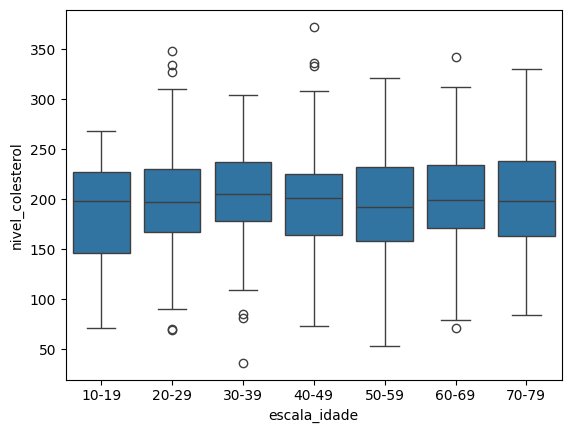

In [35]:
# Boxplot com faixas de idade
sns.boxplot(df_colesterol_bucketing, x="escala_idade", y="nivel_colesterol")

In [36]:
# Bucketing - peso
bins_peso = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
labels_peso = [
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-89",
    "90-99",
    "100-109",
    "110-119",
    "120-129",
    "130-139",
    "140-149",
    "150-159",
]
df_colesterol_bucketing["escala_peso"] = pd.cut(
    x=df_colesterol_bucketing["peso"],
    bins=bins_peso,
    labels=labels_peso,
    include_lowest=True,
)
df_colesterol_bucketing.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade,escala_peso
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39,80-89
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69,100-109
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29,60-69
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49,120-129
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79,80-89
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69,60-69
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59,110-119


<Axes: xlabel='escala_peso', ylabel='nivel_colesterol'>

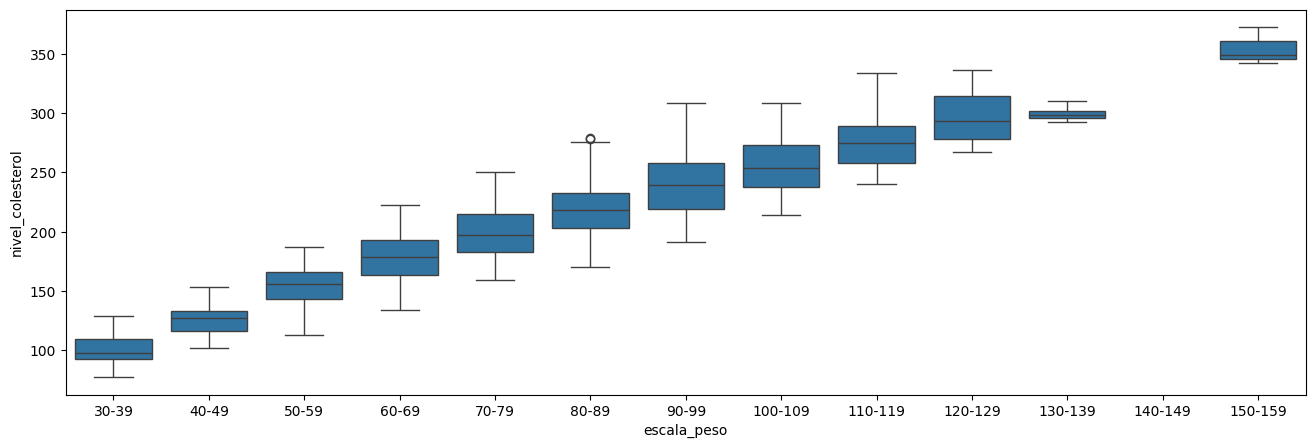

In [37]:
# Boxplot com faixas de peso
plt.figure(figsize=(16, 5))
sns.boxplot(df_colesterol_bucketing, x="escala_peso", y="nivel_colesterol")

### Preparação do Dataset para Treinamento



#### Split do Dataset Treino e Teste



O treinamento do modelo preditivo de colesterol foi iniciado utilizando o conceito de pipeline do sklearn para automatizar a transformação das variáveis independentes antes do treinamento. Foram importados módulos como model_selection, LinearRegression, preprocessing e ColumnTransformer para ajustar as colunas conforme necessário. Valores ausentes foram tratados, e métricas como r2_score, mean_absolute_error e mean_squared_error foram preparadas para avaliação do modelo. Após a preparação do DataFrame e a divisão dos dados em treino e teste, o pipeline foi construído para realizar o treinamento do modelo de forma eficiente.


In [38]:
# Criar dataset e treino de teste - remover principais outliers
df_colesterol.drop(
    df_colesterol[df_colesterol["peso"] < 40].index, axis=0, inplace=True
)
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 960 non-null    object 
 2   nivel_atividade_fisica  959 non-null    object 
 3   idade                   960 non-null    float64
 4   peso                    960 non-null    float64
 5   altura                  960 non-null    float64
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(4), object(3)
memory usage: 60.2+ KB


In [39]:
# definir variáveis de treino - independentes e dependente
X = df_colesterol.drop(columns="nivel_colesterol", axis=1)
Y = df_colesterol["nivel_colesterol"]

In [40]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.30, random_state=51
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(674, 6) (289, 6) (674,) (289,)


#### Transformação de Variáveis Categóricas para o Modelo



Foi abordada a padronização e codificação de variáveis em um pipeline de transformação de dados. Variáveis numéricas, como idade, altura e peso, foram padronizadas para ficarem na mesma escala. Variáveis categóricas nominais foram codificadas com one-hot encoding, enquanto variáveis categóricas ordinais usaram o OrdinalEncoder. Valores ausentes foram imputados com a mediana para variáveis numéricas. Por fim, foi organizado um pipeline de transformação, definindo listas de colunas para cada tipo de variável e especificando os passos de transformação necessários para cada categoria.



In [41]:
# PIPELINE
# imputar moda nas variáveis categóricas - grupo sanguineo, fumante, nível_atividade_fisica
# Padronizar variáveis numéricas - idade, altura, peso
# OneHotEncoder - variáveis categóricas nominais - grupo_saguineo, fumante
# OrdinalEncoder - variáveis categóricas ordinais - nível_atividade_fisica
# Imputar mediana nas variáveis numéricas - idade, altura, peso

# Nome das colunas
colunas_categoricas = ["grupo_sanguineo", "fumante"]
colunas_numericas = ["idade", "altura", "peso"]
colunas_ordinais = ["nivel_atividade_fisica"]

In [42]:
# Transformer Categóricas
transformer_categorias = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

#### Transformação de Variáveis Ordinais e Numéricas para o Modelo



Foi criado um Transformer para variáveis ordinais, responsável por preencher valores ausentes com a moda e definir a ordem das categorias (baixa, moderada e alta). Para as variáveis numéricas, um Transformer foi configurado para imputar valores ausentes com a mediana e escalá-las utilizando o StandardScaler, convertendo os valores para a escala Z. Após configurar os Transformers para variáveis ordinais, numéricas e categóricas, todos foram encapsulados em um ColumnTransformer, servindo como pré-processador para o treinamento do modelo.


In [43]:
# Transformer Ordinais
transformer_ordinais = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                categories=[["Baixo", "Moderado", "Alto"]], handle_unknown="error"
            ),
        ),
    ]
)

In [44]:
# Transformer Numéricas
transformer_numericas = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

In [45]:
# Criar um ColumnTransformer que encapsula todas as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformer_numericas, colunas_numericas),
        ("cat", transformer_categorias, colunas_categoricas),
        ("ord", transformer_ordinais, colunas_ordinais),
    ]
)

### Treinamento do Modelo com Pipelines



Foi desenvolvido um Pipeline principal para pré-processar os dados e treinar um modelo de regressão linear. A estrutura inclui dois passos: o pré-processamento, que ajusta as colunas ao formato necessário, e o treinamento do modelo. Utilizou-se o objeto Pipeline para integrar essas etapas. O treinamento foi realizado com o método fit, aplicando todo o fluxo, desde o pré-processamento até a regressão linear. A estrutura do Pipeline foi visualizada, e as métricas do modelo treinado foram analisadas.



In [46]:
# criar o pipeline principal - preprocessamento + treinamento
model_regr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

In [47]:
# treinar modelo
model_regr.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'altura', 'peso']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grupo_sanguineo',
                                                   'fumante']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Baixo',
                                                                                               'Moderado',
                                                                                               'Alto']]))]),
                                                  ['nivel_atividade_fisica'])])),
                ('regressor', LinearRegression())])

### Validação do Modelo



#### Análise de Métricas



As métricas do modelo de predição foram avaliadas começando pela geração das previsões no conjunto de teste. O cálculo do R2Score foi realizado para medir o quão bem as variáveis independentes explicam a variância da variável dependente, sendo que valores próximos de 1 indicam um bom desempenho do modelo. Além disso, o erro absoluto médio (MinAbsoluteError) foi calculado para medir a diferença média entre os valores previstos e reais. Por fim, o RMSE foi utilizado para considerar o impacto de outliers na análise. Essas métricas foram analisadas para avaliar a qualidade e precisão do modelo.


In [48]:
# gerar predição
Y_pred = model_regr.predict(X_test)

In [49]:
# calcular r2_score - quanto mais próximo de 1, melhor
r2_score(Y_test, Y_pred)
# pelo índice, temos um bom modelo

0.9594250724093464

In [50]:
# calcular predição de erro do modelo
# MAE (mean_absolute_error)
# o valor apresenta a mesma unidade da variável dependente
print(f"{mean_absolute_error(Y_test, Y_pred):.2f} mg/dL, para mais ou para menos")
# Para mim, é uma faixa muito baixa de variância, então podemos considerar o modelo como bom.

7.31 mg/dL, para mais ou para menos


In [54]:
# calcular RMSE (root mean absolute error)
# outliers evidenciam a diferença com o resultado do índice anterior (MAE)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 9.097649246487038


#### Análise Gráfica de Resíduos



A análise dos resíduos do modelo de regressão foi realizada, começando pelo cálculo e padronização dos resíduos. Em seguida, foi gerado um gráfico de dispersão utilizando o Seaborn para verificar a linearidade e a homoscedasticidade, avaliando se os pontos se distribuem próximos a uma reta de 45° e dentro da banda de segurança. Além disso, testes estatísticos foram aplicados para verificar se os resíduos seguem uma distribuição normal, complementados por um gráfico QQ-Plot, criado com o módulo Penguin, para validar a normalidade dos resíduos de forma visual.



In [52]:
# calcular resíduos
residuos = Y_test - Y_pred
print(residuos.dtype)

float64


In [53]:
# transformar resíduos na escala padrão
# (X - média) / desvio padrão
residuos_std = zscore(residuos)
print(residuos_std.dtype)

float64


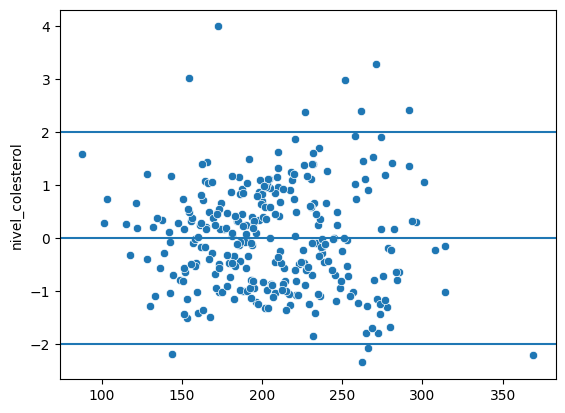

In [54]:
# verificar linearidade dos resíduos: valores entre -2 e +2 (escala padrão)
# verificar homocedasticidade - bem ditribuidos
sns.scatterplot(x=Y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

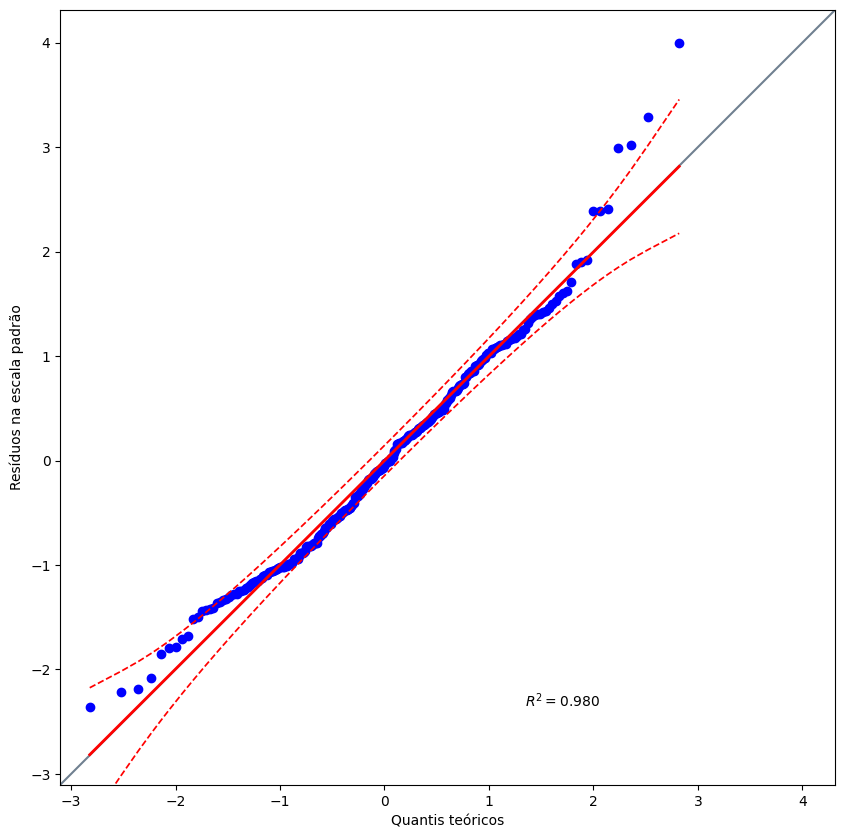

In [55]:
# checar se resíduos seguem uma distribuição normal
# QQ Plot
plt.figure(figsize=(10, 12))
pg.qqplot(residuos_std, dist="norm", confidence=0.95)
plt.xlabel("Quantis teóricos")
plt.ylabel("Resíduos na escala padrão")
plt.show()

#### Teste de Normalidade dos Resíduos



A análise de normalidade dos resíduos foi realizada utilizando quatro testes estatísticos: Shapiro-Wilk, Kolmogorov-Smirnov, Lilliefors e Anderson-Darling. Inicialmente, importamos os módulos necessários do SciPy e StatsModels. No teste de Shapiro-Wilk, observamos a estatística do teste e o valor P, com um valor P menor que 0.005 indicando a rejeição da hipótese nula de normalidade. O teste de Kolmogorov-Smirnov também apontou a falta de normalidade. Em contrapartida, o teste de Lilliefors sugeriu normalidade nos resíduos. Por fim, o teste de Anderson-Darling foi realizado, comparando a estatística do teste com valores críticos em diferentes níveis de significância. A conclusão geral foi que três dos quatro testes indicaram a ausência de normalidade nos resíduos, destacando a importância de considerar esses resultados ao avaliar o modelo.


In [56]:
# teste de normalidade de Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(
        stat_shapiro, p_value_shapiro
    )
)
# rejeitar hipótese nula - P-Value < 0.005

Estatística do Teste: 0.980774 e P-Value: 0.000627


In [57]:
# teste de Kolmogorov - Smirnov
stat_ks, p_value_ks = kstest(residuos, "norm")
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(stat_ks, p_value_ks))
# rejeitar hipótese nula - P-Value < 0.005

Estatística do Teste: 0.424559 e P-Value: 0.000000


In [58]:
# teste de Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist="norm", pvalmethod="table")
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(stat_ll, p_value_ll))
# resíduos segue uma distribuição normal - P-Value > 0.005

Estatística do Teste: 0.049554 e P-Value: 0.125333


In [59]:
# teste de Anderson-Darling
stat_and, critical_and, significance_and = anderson(residuos, dist="norm")
print(
    "Estatística do Teste: {:.6f} e Valor Crítico: {:.6f}".format(
        stat_and, critical_and[2]
    )
)
# Se o valor estatístico é maior do que o valor crítico, pode-se rejeitar o H0, ou seja, os resíduos não seguem uma distribuição normal

Estatística do Teste: 0.916928 e Valor Crítico: 0.776000


#### Teste de Homocedasticidade dos Resíduos



Realizamos a análise de homoscedasticidade utilizando o teste de Goldfeld-Quandt. Prepararam-se os dados necessários, incluindo resíduos e variáveis independentes. Foi criado um pipeline específico para o pré-processamento, aplicado aos dados de teste antes da execução do teste. Os resultados mostraram que não é possível rejeitar a hipótese nula, indicando que os resíduos apresentam variância homogênea em relação às variáveis independentes. Esse resultado valida o modelo, concluindo a análise de resíduos e permitindo avançar para previsões e entrega do modelo ao usuário final.



In [60]:
# Teste de Homocedasticidade de Goldfeld-Quandt
pipe = Pipeline(steps=[("preprocessor", preprocessor)])
X_test_transformed = pipe.fit_transform(X_test)

test_goldfeld = het_goldfeldquandt(residuos, X_test_transformed)
stat_goldfeld, p_value_goldfeld = test_goldfeld[0], test_goldfeld[1]
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(
        stat_goldfeld, p_value_goldfeld
    )
)

Estatística do Teste: 0.671614 e P-Value: 0.989396


### Predição de Valores



Nesta etapa final da construção do modelo, focamos em como realizar predições individuais usando o modelo treinado. Começamos criando um dicionário com os valores de entrada, utilizando os mesmos nomes de variáveis do dataset original. O pipeline que desenvolvemos é fundamental nesse processo, pois ele cuida de todas as transformações e pré-processamento necessários, permitindo que os dados sejam passados no estado natural.

Uma vez configurados os valores, o modelo retorna a predição diretamente. Também abordamos como salvar o modelo treinado junto com o pipeline completo em um arquivo chamado model_lr_multiple.pkl. Isso assegura que todas as etapas de pré-processamento e o modelo de regressão linear estejam incluídos para uso posterior.

Com o modelo salvo, concluímos a fase de modelagem e predição. No próximo vídeo, abordaremos a criação de uma interface gráfica simples que permitirá ao usuário interagir com o modelo e fazer predições de forma intuitiva.


In [61]:
# definir valores aleatórios para exemplo de predição
prediction_random_values = {
    "grupo_sanguineo": "O",
    "fumante": "Não",
    "nivel_atividade_fisica": "Alto",
    "idade": 40,
    "peso": 70,
    "altura": 180,
}
sample_df = pd.DataFrame(prediction_random_values, index=[1])
sample_df

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura
1,O,Não,Alto,40,70,180


In [62]:
# calcular predição
model_regr.predict(sample_df)

array([165.32375099])

In [63]:
# salvar modelo
joblib.dump(model_regr, "../data/model_lr_multiple.plk")

['../data/model_lr_multiple.plk']